In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
os.chdir("/kaggle/input/ravdess/Ravdess")

In [3]:
def load_and_get_audio_data(path_to_data_for_audio):
    """
    
    path_to_data_for_audio: Path to the Audio_Speech_Actors_01 folder.
    output: Pandas Dataframe
    
    source: https://github.com/mkosaka1/Speech_Emotion_Recognition
    """

    actor_folders = os.listdir(path_to_data_for_audio)


    emotion = []
    gender = []
    actor = []
    file_path = []
    for i in actor_folders:
        filename = os.listdir(path_to_data_for_audio + i) #iterate over Actor folders
        for f in filename: # go through files in Actor folder
            part = f.split('.')[0].split('-')
            emotion.append(int(part[2]))
            actor.append(int(part[6]))
            bg = int(part[6])
            if bg%2 == 0:
                bg = "female"
            else:
                bg = "male"
            gender.append(bg)
            file_path.append(path_to_data_for_audio + i + '/' + f)
    # PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
    audioDeep_df = pd.DataFrame(emotion)
    audioDeep_df = audioDeep_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
    audioDeep_df = pd.concat([pd.DataFrame(gender),audioDeep_df,pd.DataFrame(actor)],axis=1)
    audioDeep_df.columns = ['gender','emotion','actor']
    audioDeep_df = pd.concat([audioDeep_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
    

        
    
    
    #df_combined = pd.concat([audioDeep_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
    #df_combined = df_combined.fillna(0)
    #df_combined.drop(columns='path',inplace=True)
    
    return audioDeep_df

In [4]:
#path_to_data_for_audio = "Data/AudioEmotion/AudioEmotion/Audio_Speech_Actors_01-24/"
path_to_data_for_audio = './Audio Emotion/'
audioDeep = load_and_get_audio_data(path_to_data_for_audio)
#audioDeep.columns= ['gender', 'emotion', 'actor', "mel_spectrogram"]
audioDeep.head()

,gender,emotion,actor,path
0,female,surprise,2,./Audio Emotion/Actor_02/03-01-08-01-01-01-02.wav
1,female,neutral,2,./Audio Emotion/Actor_02/03-01-01-01-01-01-02.wav
2,female,disgust,2,./Audio Emotion/Actor_02/03-01-07-02-01-02-02.wav
3,female,disgust,2,./Audio Emotion/Actor_02/03-01-07-01-01-02-02.wav
4,female,neutral,2,./Audio Emotion/Actor_02/03-01-01-01-02-01-02.wav


In [5]:
# Split training data into valid and test.
train_dataz, test_dataz = train_test_split(audioDeep, test_size=0.2, random_state=0,
                               stratify=audioDeep[['emotion','gender','actor']])

train_dataz, valid_dataz = train_test_split(train_dataz, test_size=0.25, random_state=0)

train = train_dataz
valid = valid_dataz
test = test_dataz


print(f'Number of training examples: {len(train_dataz)}')
print(f'Number of validation examples: {len(valid_dataz)}')
print(f'Number of testing examples: {len(test_dataz)}')

Number of training examples: 864
Number of validation examples: 288
Number of testing examples: 288


In [6]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [7]:
def get_melspectrogram_db(file_path, sr=44100, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr,duration=5) # i added duration, and changed sr
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [8]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      #file_path = os.path.join(base,row[in_col])
      file_path = os.path.join(base,row[in_col])       
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['emotion']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [9]:
class ESC50Model(nn.Module):
  def __init__(self, input_shape, batch_size=8, num_cats=8): # Bacth size originally 16
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x


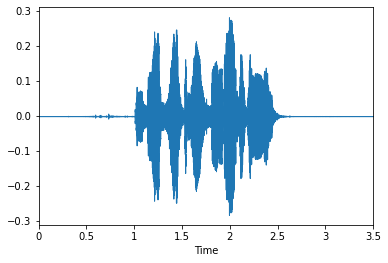

In [10]:
filename = valid.iloc[0]['path']
wav, sr = librosa.load(filename, sr=44100, duration = 5)
librosa.display.waveplot(wav, sr)

In [11]:
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 3.503514739229025 seconds


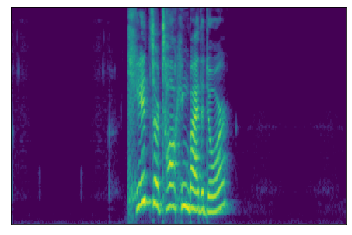

In [12]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(filename, sr)), cmap='viridis')

In [13]:
train_data = ESC50Data('', train, 'path', 'emotion')
valid_data = ESC50Data('', valid, 'path', 'emotion')
test_data = ESC50Data('', test, 'path', 'emotion')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [14]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

In [15]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [16]:
model = ESC50Model(input_shape=(1,128,431), batch_size=8, num_cats=8).to(device)

In [17]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 30 # THis used to be 60, works with 5
train_losses = []
valid_losses = []

In [19]:
def train(model, loss_fn, train_loader, valid_loader, test_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}') # Edit
    
    # Evaluate the model against the test data
    trace_yz = []
    trace_yzhat = []

    # new
    y_pred_list = []
    y_true_list = []
    

    for i, data in enumerate(test_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)  
      y_hat = model(x)
      y_test_pred = model(x)
      _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
      y_pred_list.append(y_pred_tag.cpu().numpy())
      y_true_list.append(y.cpu().numpy())
    
    
      ####
    
      #x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      #y_test_pred = model(x_batch)
      #_, y_pred_tag = torch.max(y_test_pred, dim = 1)
      #y_pred_list.append(y_pred_tag.cpu().numpy())
      #y_true_list.append(y_batch.cpu().numpy())
    
      ####
    
      #y_pred_list.append(y_pred_tag.cpu().numpy())
      #y_true_list.append(y.cpu().numpy())
    

      #Extra metrics

      trace_yz.append(y.cpu().detach().numpy())
      trace_yzhat.append(y_hat.cpu().detach().numpy())
      #y_true_list.append(y.cpu().numpy())
        

      # new
    #y_pred_list = [i[0][0] for i in y_pred_list]
    #for y in y_test:
    #    results.append(..., y)
    #y_true_list = [i[0] for i in y_true_list]
    #for y in y_test:
    #    results.append(..., y)
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    y_pred_list = np.concatenate(y_pred_list)
    y_true_list = np.concatenate(y_true_list)
    
    trace_yz = np.concatenate(trace_yz)
    trace_yzhat = np.concatenate(trace_yzhat)

    # new

    #Extra metrics
    accuracyz = np.mean(trace_yzhat.argmax(axis=1)==trace_yz)
    
    
    print(f'Epoch - {epoch} Test-Accuracy : {accuracyz}') # Edit
    #print(classification_report(y_true_list, y_pred_list))
    #print(classification_report(y_true_list, y_pred_list))
    #print(f'Epoch - {epoch} Test-Accuracy : {accuracyz} F1 : {f1_scorez} Recall : {recall_scorez} Precision : {precision_scorez}') # Edit
    
    
    

    
    #print(f'Epoch - {epoch} Test-Loss : {np.mean(valid_losses[-1])} Test-Accuracy : {accuracy} F1 : {accuracy} Recall : {accuracy} Precision : {accuracy}') # Edit

    print("F1 Score: ", f1_score(y_true_list, y_pred_list, average='macro'))
    print("Recall: ", recall_score(y_true_list, y_pred_list, average='macro'))
    print("Precision: ", precision_score(y_true_list, y_pred_list, average='macro'))  

In [20]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, test_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch - 1 Train-Loss : 2.142937383166066
Epoch - 1 Valid-Loss : 1.7956170174810622 Valid-Accuracy : 0.3055555555555556
Epoch - 1 Test-Accuracy : 0.3090277777777778
F1 Score:  0.21160342351327655
Recall:  0.29717752020383603
Precision:  0.2993999094202898


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch - 2 Train-Loss : 1.4313255244935001
Epoch - 2 Valid-Loss : 1.4197864532470703 Valid-Accuracy : 0.4548611111111111
Epoch - 2 Test-Accuracy : 0.5208333333333334
F1 Score:  0.480159204923245
Recall:  0.49579550813103446
Precision:  0.6414646125435317
Epoch - 3 Train-Loss : 0.9885873474456646
Epoch - 3 Valid-Loss : 1.3603552497095532 Valid-Accuracy : 0.4861111111111111
Epoch - 3 Test-Accuracy : 0.5138888888888888
F1 Score:  0.5097921505813023
Recall:  0.5093058464768991
Precision:  0.5489060129353955
Epoch - 4 Train-Loss : 0.5771410825351874
Epoch - 4 Valid-Loss : 1.28198461400138 Valid-Accuracy : 0.53125
Epoch - 4 Test-Accuracy : 0.5416666666666666
F1 Score:  0.5368007502857357
Recall:  0.5251585629875104
Precision:  0.6939562038365947
Epoch - 5 Train-Loss : 0.35613941263269494
Epoch - 5 Valid-Loss : 1.1350944447848532 Valid-Accuracy : 0.5798611111111112
Epoch - 5 Test-Accuracy : 0.5972222222222222
F1 Score:  0.5922381689597846
Recall:  0.5931419798196114
Precision:  0.6329723405691

In [21]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 ESC50Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

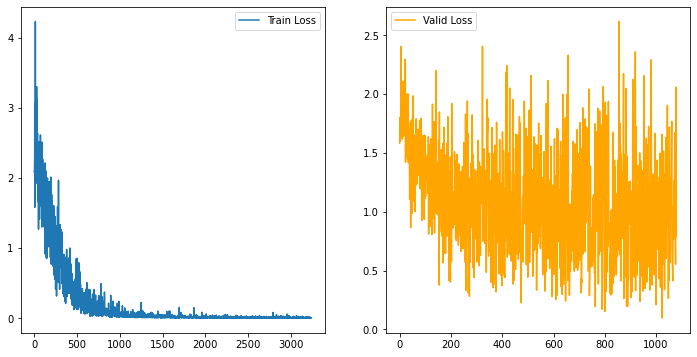

In [22]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
